<a href="https://colab.research.google.com/github/DODHIAMBOO/project_1/blob/main/TensorFlow_Hub_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Use a TensorFlow Hub MobileNet for prediction**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

**Here we download the classifier(download MobileNet model and creating keras model from it)**

In [ ]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

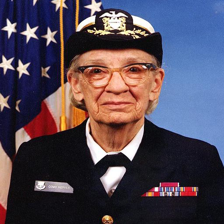

In [ ]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [ ]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 3s 3s/step


(1, 1001)

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

**Decoding The Predictions**

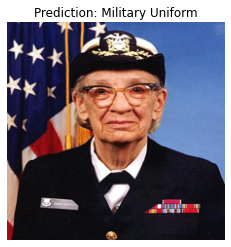

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

**Tensorflow Hub Models for Flowers Dataset**

In [ ]:
(training_set, validation_set), info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[30%:]'],
)

num_training_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
num_validation_examples = info.splits['train'].num_examples

In [ ]:
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 3670
Total Number of Validation Images: 3670 



In [ ]:
for i, example in enumerate(training_set.take(3)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3


In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

**Running Classifier on Batch of Images**

In [ ]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 1s 636ms/step


array(['cardoon', 'daisy', 'pot', 'trifle', 'daisy', 'cardoon',
       'picket fence', 'daisy', 'goldfish', 'vase', 'wig', 'daisy', 'bee',
       'velvet', 'hen-of-the-woods', 'fig', 'admiral', 'plate rack',
       'bolo tie', 'bee', 'pot', 'daisy', 'vase', 'cardoon', 'zucchini',
       'handkerchief', 'daisy', 'daisy', 'bee', 'daisy', 'bee', 'conch'],
      dtype='<U30')

**Trying to See If the Model ImageNet can predict the images of Flowers in the Dataset** 

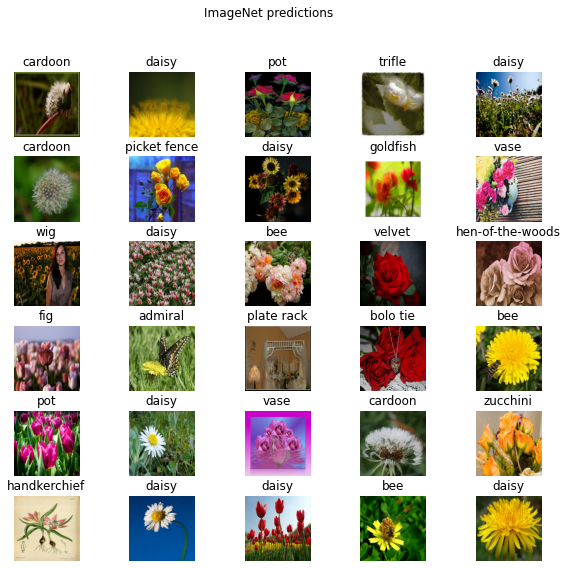

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [ ]:
URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [ ]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [ ]:
feature_extractor.trainable = False

In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(5)
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


**Training The Model**

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 24s 187ms/step - loss: 0.8110 - accuracy: 0.6940 - val_loss: 0.4357 - val_accuracy: 0.8525
Epoch 2/6
81/81 [==============================] - 6s 69ms/step - loss: 0.3920 - accuracy: 0.8606 - val_loss: 0.3405 - val_accuracy: 0.8875
Epoch 3/6
81/81 [==============================] - 6s 68ms/step - loss: 0.3039 - accuracy: 0.9007 - val_loss: 0.2729 - val_accuracy: 0.9148
Epoch 4/6
81/81 [==============================] - 6s 73ms/step - loss: 0.2529 - accuracy: 0.9194 - val_loss: 0.2503 - val_accuracy: 0.9210
Epoch 5/6
81/81 [==============================] - 8s 99ms/step - loss: 0.2185 - accuracy: 0.9334 - val_loss: 0.2339 - val_accuracy: 0.9241
Epoch 6/6
81/81 [==============================] - 5s 68ms/step - loss: 0.1917 - accuracy: 0.9436 - val_loss: 0.2088 - val_accuracy: 0.9377


PLOT OF VALIDATION AND TRAIN ACCURACY AND LOSS GRAPHS






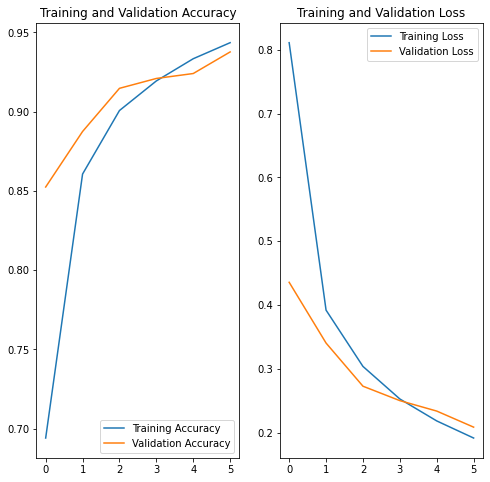

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#FROM the graph we can say validation performance is higher than training performnace 
#one of the main reason is because validation accuracy is measured at the end of the epoch while training accuracy/performance is the average values accross the epoch



CHECKING PREDICTION IF ITS CORRECT







In [ ]:
class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 1s 694ms/step


array(['dandelion', 'dandelion', 'roses', 'roses', 'daisy', 'dandelion',
       'roses', 'sunflowers', 'roses', 'roses', 'sunflowers', 'tulips',
       'roses', 'roses', 'roses', 'tulips', 'dandelion', 'roses', 'roses',
       'dandelion', 'tulips', 'daisy', 'roses', 'dandelion', 'roses',
       'tulips', 'daisy', 'tulips', 'dandelion', 'dandelion',
       'sunflowers', 'roses'], dtype='<U10')

In [ ]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 4 4 1 0 4 3 4 4 3 2 4 4 4 2 0 4 4 0 2 1 4 0 4 2 1 2 0 0 3 4]
Predicted labels:  [0 0 4 4 1 0 4 3 4 4 3 2 4 4 4 2 0 4 4 0 2 1 4 0 4 2 1 2 0 0 3 4]


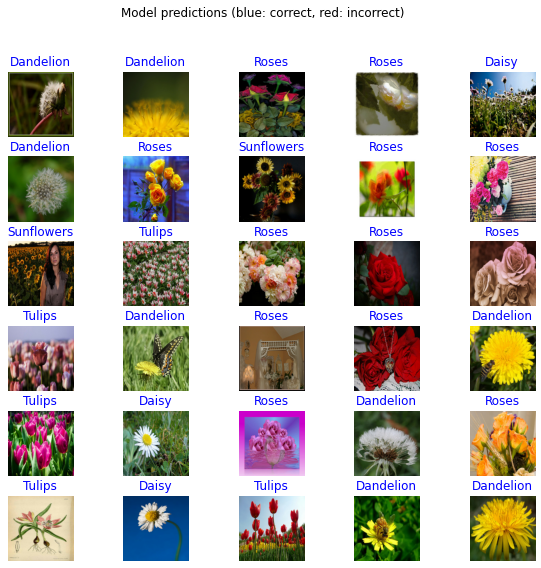

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")